In [2]:
import pandas as pd

url = "https://huggingface.co/datasets/Adilbai/stock-dataset/resolve/main/data/train-00000-of-00001.parquet"
df = pd.read_parquet(url)

D:\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
D:\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


本 EDA 的目标并非仅描述数据，而是评估该多股票时间序列数据是否适合用于
（1）短期价格方向预测 / 相对收益预测，
（2）跨股票横截面排序建模，
并识别哪些特征在时间与个股维度上具有潜在预测稳定性。
Given historical technical indicators of S&P 500 stocks,
predict whether the stock price will go up or down over a short-term horizon.

#### 1.1 数据结构基本信息

我们首先查看整个数据集的规模以及各字段名，了解包含哪些内容。此数据集包含多个股票在多个交易日的记录，初步感知字段是否可用于后续分析（如技术指标、滞后项、未来标签等）。

本文将数据视为 panel data（Ticker × Time），
后续 EDA 将分别从

-时间维度（单一股票的走势与波动）

-横截面维度（同一时间不同股票的相对表现）
进行分析。

In [34]:
df.shape  # 行数、列数
df.columns.tolist()  # 所有字段名
df_raw = df.copy()

print("Data Dimensions(#rows, #columns):", df.shape)
print("All field names", df.columns.tolist()[:])

Data Dimensions(#rows, #columns): (620095, 73)
All field names ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Ticker', 'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'MACD_Histogram', 'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'BB_Width', 'BB_Position', 'Volatility', 'Price_Change', 'Price_Change_5d', 'High_Low_Ratio', 'Open_Close_Ratio', 'Volume_SMA', 'Volume_Ratio', 'Close_lag_1', 'Close_lag_2', 'Close_lag_3', 'Close_lag_5', 'Close_lag_10', 'Volume_lag_1', 'Volume_lag_2', 'Volume_lag_3', 'Volume_lag_5', 'Volume_lag_10', 'Price_Change_lag_1', 'Price_Change_lag_2', 'Price_Change_lag_3', 'Price_Change_lag_5', 'Price_Change_lag_10', 'RSI_lag_1', 'RSI_lag_2', 'RSI_lag_3', 'RSI_lag_5', 'RSI_lag_10', 'MACD_lag_1', 'MACD_lag_2', 'MACD_lag_3', 'MACD_lag_5', 'MACD_lag_10', 'Volatility_lag_1', 'Volatility_lag_2', 'Volatility_lag_3', 'Volatility_lag_5', 'Volatility_lag_10', 'Future_Return_1d', 'Future_Up_1d', 'Future_Category_

#### 1.2 缺失值检查

缺失值会影响模型质量或统计计算的可靠性。我们统计每个字段的缺失值数量，发现缺失主要集中在部分技术指标或滞后项字段，这通常是由滚动计算窗口前期数据不足导致的（如前5天、前10天的数据）。这类缺失是可接受的，不属于数据错误。
虽然部分技术指标存在缺失，但这主要集中在样本序列的起始阶段，属于正常计算过程中的“窗口不足”现象。而原始行情数据（如 OHLCV）无任何缺失，说明数据质量整体良好。


In [33]:
missing = df.isnull().sum()
missing_pct = (missing / len(df)).sort_values(ascending=False)

# 只看缺失率大于 0.5% 的字段
significant_missing = missing_pct[missing_pct > 0.005]

# 合并为 DataFrame
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct
})

print("缺失率 >0.5% 的字段数:", len(significant_missing))
display(significant_missing)

# 只保留有缺失的字段，并按缺失率降序排序
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing %', ascending=False)

missing_df.head()  # 查看缺失最严重的字段


缺失率 >0.5% 的字段数: 0


Series([], dtype: float64)

,Missing Count,Missing %


In [31]:
core_fields = ['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Volume']
core_missing = df[core_fields].isnull().sum()
core_missing = core_missing[core_missing > 0]

if not core_missing.empty:
    print("🚨 核心字段存在缺失：")
    display(core_missing)
else:
    print("✅ 所有核心字段（OHLCV）无缺失。")

missing_rows = df[df[core_fields].isnull().any(axis=1)]
print("存在 %d 行缺失了关键字段：" % len(missing_rows))
missing_rows[['Date', 'Ticker'] + core_fields].head()


✅ 所有核心字段（OHLCV）无缺失。
存在 0 行缺失了关键字段：


,Date,Ticker,Date,Ticker,Open,High,Low,Close,Volume


##### 1.2 缺失值分析总结

虽然所有字段缺失率均小于 1%，我们进一步分析如下：

- **核心字段（OHLCV + Ticker/Date）** 无任何缺失，确保了主建模字段的完整性
- 所有字段均无缺失

后续建模时可统一丢弃前10天，规避技术指标计算期带来的空值。


#### 1.3 日期字段处理与时间范围确认

时间序列建模对时间字段的格式和连续性要求极高，因此我们将 `Date` 字段转换为标准的 `datetime` 类型，并查看数据的起止时间范围、时间点总数。确保后续分析和可视化以时间为基础展开。


In [10]:
# df['Date'] = pd.to_datetime(df['Date'])  # 确保是 datetime 类型

print(df['Date'].min(), '→', df['Date'].max())
print("Total dates:", df['Date'].nunique())


2020-07-15 00:00:00-04:00 → 2025-06-27 00:00:00-04:00
Total dates: 1245


#### 1.4 每日数据记录数量趋势

我们希望确认：是否每个交易日都包含了多个股票数据（如 S&P500 的大部分成分股），并检查是否存在明显的数据缺失时间段。下图展示了每个日期的记录条数，若出现断崖式下跌则可能是数据不全或市场非交易日。


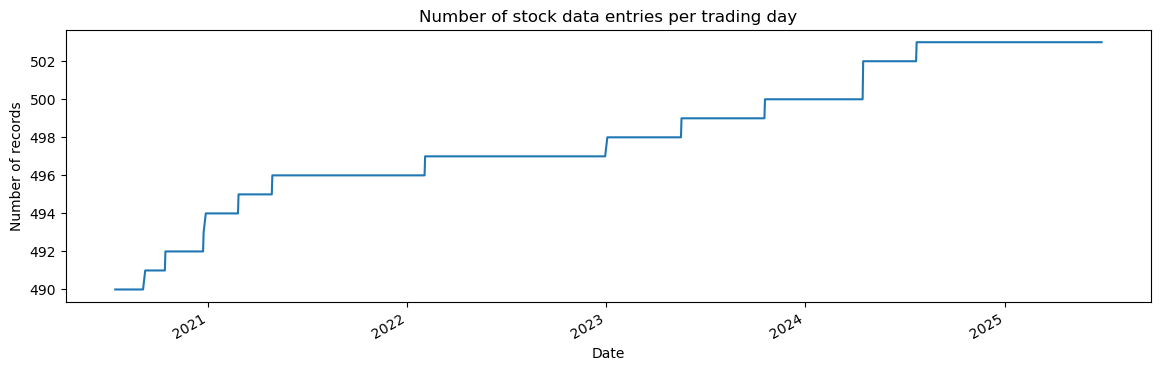

In [19]:
daily_counts = df.groupby('Date')['Ticker'].count()
daily_counts.plot(figsize=(14, 4), title='Number of stock data entries per trading day')
plt.ylabel('Number of records')
plt.show()


#### 每日数据条目数分析

我们统计了每个交易日的数据记录数量，发现如下：

- 数据在最初阶段（2020–2021）并不覆盖全部成分股，约为 490 条记录/天；
- 随着时间推移，数据量逐步增加，呈现阶梯状上升；
- 从约 2024 年开始，数据条目数趋于稳定，接近 S&P500 全量（约 502 条/日）；
- 这说明数据集构建过程中存在逐步补全过程。

#### 1.5 重复数据检查

重复记录可能在数据清洗或聚合过程中误生成。我们先检查整行是否有完全重复的样本，然后进一步检查是否存在某股票在某日重复记录的情况。理想状态是每只股票在一个交易日只有一条记录。


In [15]:
df.duplicated().sum()  # 完全重复的行数
df.duplicated(subset=['Date', 'Ticker']).sum()  # 某股票某天是否重复


0

#### 1.6 数值分布分析：价格与成交量

我们通过描述性统计查看核心价格字段（开盘、收盘、最高、最低）和成交量的分布情况。这有助于提前发现异常值（如 0、极大或极小），并了解价格水平的总体范围，为后续箱线图分析或标准化处理提供参考。


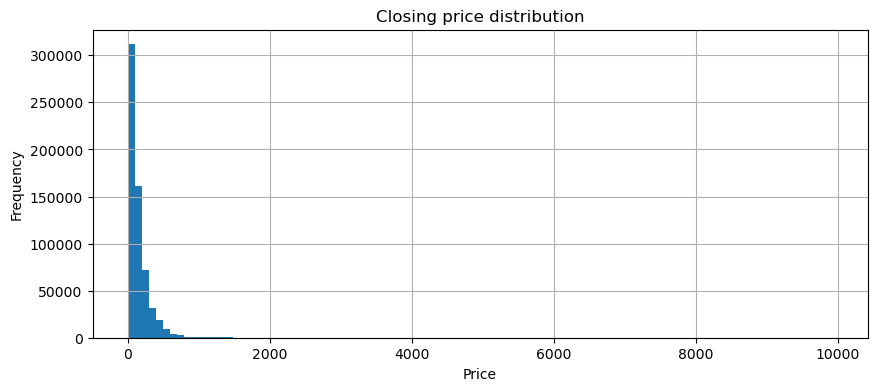

In [18]:
# 价格字段直方图
df['Close'].hist(bins=100, figsize=(10,4))
plt.title("Closing price distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

In [35]:
df[df['Close'] <= 0]


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,SMA_5,...,Future_Category_1d,Future_Return_5d,Future_Up_5d,Future_Category_5d,Future_Return_10d,Future_Up_10d,Future_Category_10d,Future_Return_20d,Future_Up_20d,Future_Category_20d


#### Closing Price Distribution Analysis

We plotted a histogram of the `Close` field to explore the overall price distribution across the dataset. This analysis helps us:

- Identify the typical price range of most S&P500 stocks (concentrated below $200),
- Spot rare but high-value stocks (long right tail, some exceeding $1000+),
- Detect potential outliers or invalid entries (e.g., zero or negative prices).

The distribution is highly right-skewed, which suggests further preprocessing such as normalization or outlier treatment may be necessary before modeling.


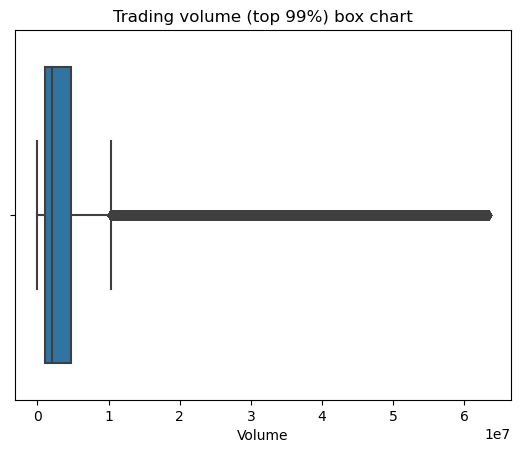

In [20]:
# 成交量箱线图（排除极端值）
import seaborn as sns
sns.boxplot(data=df[df['Volume'] < df['Volume'].quantile(0.99)], x='Volume')
plt.title("Trading volume (top 99%) box chart")
plt.show()


In [3]:
import numpy as np

vol = df['Volatility'].dropna()

vol.describe(percentiles=[0.9, 0.95, 0.99])


count    620095.000000
mean          5.222204
std          11.091737
min           0.041749
50%           2.684145
90%          10.732874
95%          16.074831
99%          39.435462
max         479.241952
Name: Volatility, dtype: float64

The volatility distribution exhibits strong right-skewness and heavy tails.
While the majority of observations show relatively low volatility levels (median ≈ 2.68), a small fraction of extreme observations contributes disproportionately to overall risk.
In particular, the top 1% of observations display volatility levels more than an order of magnitude higher than the median, indicating the presence of extreme market regimes.

In [4]:
(vol > vol.quantile(0.99)).mean()

0.010000080632806264

Approximately 1% of observations exceed the 99th percentile volatility threshold, yet these observations dominate the variance structure of the dataset.

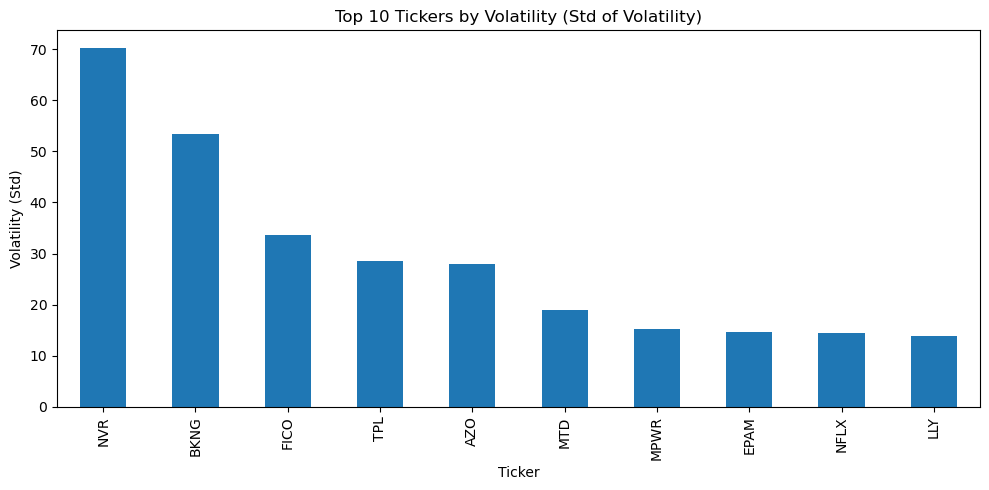

In [10]:
ticker_vol = (
    df.groupby('Ticker')['Volatility']
      .std()
      .sort_values(ascending=False)
)

import matplotlib.pyplot as plt

top_n = 10
top_ticker_vol = ticker_vol.head(top_n)

plt.figure(figsize=(10, 5))
top_ticker_vol.plot(kind='bar')
plt.title('Top 10 Tickers by Volatility (Std of Volatility)')
plt.xlabel('Ticker')
plt.ylabel('Volatility (Std)')
plt.tight_layout()
plt.show()


The most volatile tickers exhibit substantially higher risk levels than the market median; however, volatility decreases gradually across the top-ranked assets rather than being dominated by a single extreme outlier.

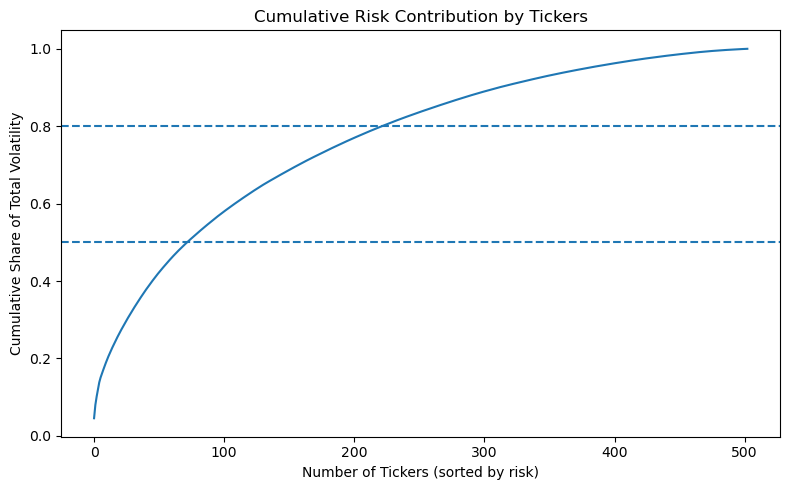

In [12]:
import numpy as np

# 计算风险占比
risk_share = ticker_vol / ticker_vol.sum()

# 按风险从高到低排序
risk_share_sorted = risk_share.sort_values(ascending=False)

# 累计风险占比
cum_risk = risk_share_sorted.cumsum()

plt.figure(figsize=(8, 5))
plt.plot(cum_risk.values)
plt.axhline(0.5, linestyle='--')
plt.axhline(0.8, linestyle='--')
plt.xlabel('Number of Tickers (sorted by risk)')
plt.ylabel('Cumulative Share of Total Volatility')
plt.title('Cumulative Risk Contribution by Tickers')
plt.tight_layout()
plt.show()


Cross-sectional analysis of volatility reveals a moderate concentration of risk across assets.
Approximately 15–20% of tickers account for half of the total volatility, while risk accumulation remains gradual rather than dominated by a small number of extreme assets.
This suggests that although market risk is not excessively concentrated, asset-level heterogeneity remains non-negligible and should be accounted for in subsequent modeling.

 ####1.8 

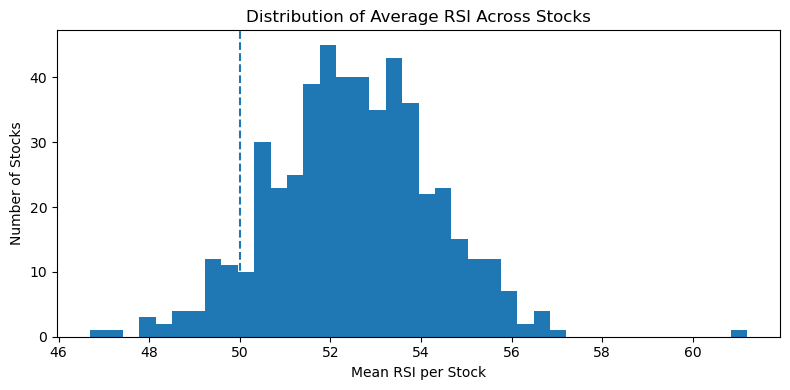

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

rsi_mean = (
    df.groupby('Ticker')['RSI']
      .mean()
      .dropna()
)

plt.figure(figsize=(8, 4))
plt.hist(rsi_mean, bins=40)
plt.axvline(50, linestyle='--')
plt.xlabel('Mean RSI per Stock')
plt.ylabel('Number of Stocks')
plt.title('Distribution of Average RSI Across Stocks')
plt.tight_layout()
plt.show()


平均 RSI 在 46–58

中位数在 50

没有股票超过 62
RSI 的中心趋势在股票之间高度一致
The average RSI levels across stocks are tightly clustered around the neutral level of 50, with no stock exhibiting an excessively high long-term RSI bias. Indicates that we can use the data as pooled. 

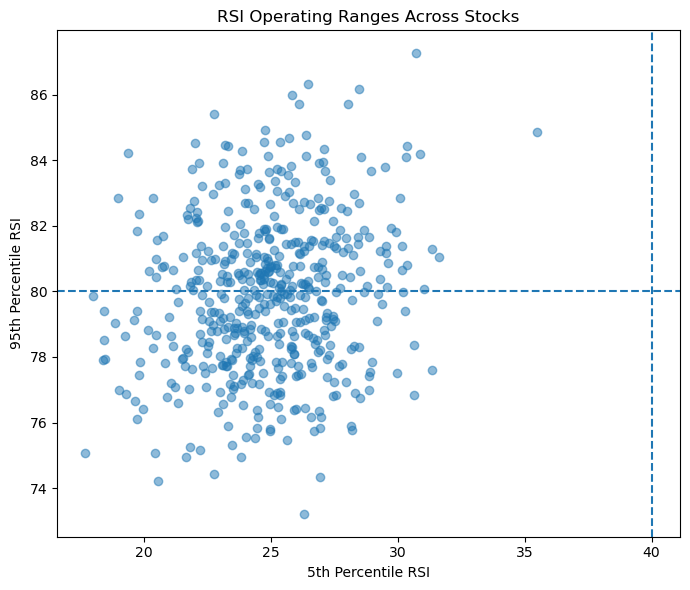

In [15]:
rsi_range = (
    df.groupby('Ticker')['RSI']
      .quantile([0.05, 0.95])
      .unstack()
      .dropna()
)

rsi_range.columns = ['RSI_5pct', 'RSI_95pct']


plt.figure(figsize=(7, 6))
plt.scatter(rsi_range['RSI_5pct'], rsi_range['RSI_95pct'], alpha=0.5)

plt.axvline(40, linestyle='--')
plt.axhline(80, linestyle='--')

plt.xlabel('5th Percentile RSI')
plt.ylabel('95th Percentile RSI')
plt.title('RSI Operating Ranges Across Stocks')
plt.tight_layout()
plt.show()


所有股票的 RSI 下界 < 40

但 只有约一半股票的 RSI 上界 < 80

多数股票的 RSI 下界集中在 28–32

少数极端在 ~35

意思是RSI 在“超卖区”是高度一致的，但在“超买区”存在异质性。
While all stocks exhibit RSI values reaching the lower range associated with weak momentum, only a subset frequently reaches conventional overbought levels.
This suggests asymmetry in RSI operating ranges across stocks, particularly on the upper tail.

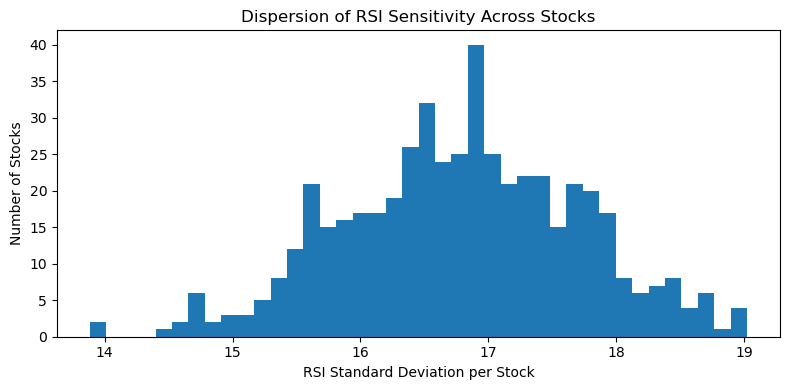

In [16]:
rsi_std = (
    df.groupby('Ticker')['RSI']
      .std()
      .dropna()
)

plt.figure(figsize=(8, 4))
plt.hist(rsi_std, bins=40)
plt.xlabel('RSI Standard Deviation per Stock')
plt.ylabel('Number of Stocks')
plt.title('Dispersion of RSI Sensitivity Across Stocks')
plt.tight_layout()
plt.show()


区间宽度 ≈ 4

极端值不超过 20

没有 fat-tail

👉 这说明：

RSI 的“敏感度”在股票间：

有差异

但不夸张

不会主导模型。The dispersion of RSI standard deviation across stocks is moderate, indicating some heterogeneity in indicator sensitivity but no extreme outliers.

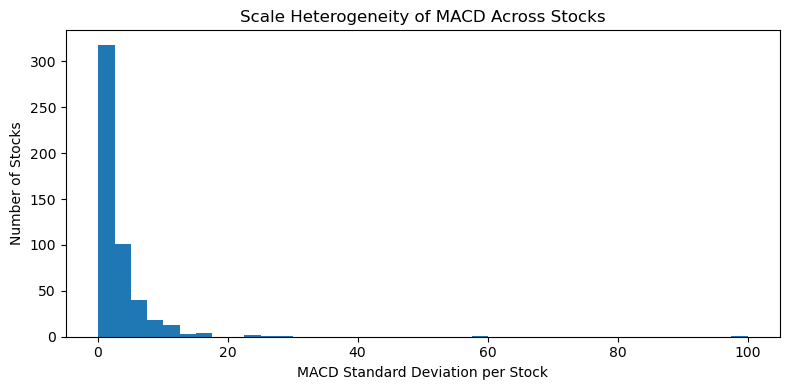

In [17]:
macd_std = (
    df.groupby('Ticker')['MACD']
      .std()
      .dropna()
)

plt.figure(figsize=(8, 4))
plt.hist(macd_std, bins=40)
plt.xlabel('MACD Standard Deviation per Stock')
plt.ylabel('Number of Stocks')
plt.title('Scale Heterogeneity of MACD Across Stocks')
plt.tight_layout()
plt.show()


MACD std 分布从 0 到 100

大多数在 0–10

少量在 20、60、甚至 100。意味着同样一个 MACD 数值，对不同股票代表完全不同的“趋势强度”。 Indicating that raw MACD values are not directly comparable across stocks.

 #### 1.9 feature audit

In [23]:
features = [
    'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50',
    'EMA_12', 'EMA_26',
    'MACD', 'MACD_Signal', 'MACD_Histogram',
    'RSI'
]

corr_market = df[features].corr()

upper = corr_market.abs().where(
    np.triu(np.ones(corr_market.shape), k=1).astype(bool)
)

upper.stack().sort_values(ascending=False)


SMA_10          EMA_12            0.999969
SMA_5           EMA_12            0.999863
                SMA_10            0.999850
EMA_12          EMA_26            0.999796
SMA_10          EMA_26            0.999686
SMA_5           EMA_26            0.999391
SMA_20          EMA_26            0.992727
                EMA_12            0.992602
SMA_10          SMA_20            0.992521
SMA_5           SMA_20            0.992153
SMA_20          SMA_50            0.972259
SMA_50          EMA_26            0.965520
                EMA_12            0.964543
SMA_10          SMA_50            0.964271
SMA_5           SMA_50            0.963715
MACD            MACD_Signal       0.954556
MACD_Histogram  RSI               0.361939
MACD            RSI               0.340055
                MACD_Histogram    0.339307
SMA_5           MACD_Signal       0.267620
SMA_10          MACD_Signal       0.262629
EMA_12          MACD_Signal       0.258093
SMA_5           MACD              0.250140
MACD_Signal

有些特征展现了结构性冗余，他们的相关性在0.96-0.99，他们几乎在表达同一件事情。比如SMA5， SMA10，EMA12等等。也有的特征中等相关，比如RSI和MACD，他们的相关性是0.24， 意味着两个指标在某些市场状态下会一起变化，但大多数时候仍然在捕捉不同信号维度。还有信息正交的特征，比如RSI分别和EMA，SMA，他们的相关性接近于0.00。还有MACD与SMA。这说明MACD和RSI分别remains sufficiently distinct to avoid redundancy.

To assess whether strong correlations are structural or aggregation-driven, we examine a representative pair of moving-average-based indicators (SMA_20 and SMA_50).
Similar behavior is observed across other moving-average and EMA combinations.

In [31]:
corr_by_ticker = (
    df.groupby('Ticker')[features] #对每一只股票，单独计算一套特征相关性结构
      .corr()
)

# 构建representative stock
corr_mean = corr_by_ticker.groupby(level=1).mean()

print("SMA20 vs SMA50")
pd.Series({
    'Market-level corr': corr_market.loc['SMA_20', 'SMA_50'],# 市场整体
    'Average per-stock corr': corr_mean.loc['SMA_20', 'SMA_50']# 个股平均
})


SMA20 vs SMA50


Market-level corr         0.972259
Average per-stock corr    0.758324
dtype: float64

SMA_20 and SMA_50 exhibit consistent trend behavior across stocks.They have strong structural alignment, but not exact equivalence.

In [20]:
import numpy as np

upper = corr_market.abs().where(
    np.triu(np.ones(corr_market.shape), k=1).astype(bool)
)

high_corr_pairs = (upper > 0.9).sum().sum()
total_pairs = upper.count().sum()

high_corr_pairs / total_pairs


0.35555555555555557

A substantial proportion(35.6%) of feature pairs exhibit very high correlations, particularly among indicators derived from similar moving-average constructions, suggesting that the effective dimensionality of the feature space is lower than the raw feature count.

下一步我们可以使用什么模型，什么模型不合适。
| 维度   | 建议                            |
| ---- | ----------------------------- |
| 任务类型 | **二分类（Up / Down）**            |
| 预测对象 | 下一周期价格方向                      |
| 时间尺度 | **固定一个短期窗口**（如 1-day 或 5-day） |
| 数据结构 | Panel data（Ticker × Time）     |
| 标签   | future return > 0 → 1 else 0  |

Logistic Regression - baseline

Random Forest - non-linar base

XGBoost - ensemble

SVM - geometry

MLP / LSTM - deep learning
